In [1]:
cd ../

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

In [3]:
# specify path to the lightcurve
lc_path = "symbiotic/puvulASAS-SN.csv"

# object name (or abbreviation)
n = "PUVul"

# resample length for time-sorted LC purposes
resample_len = '5d'

# LC Data Munging

In [4]:
lc = pd.read_csv(lc_path, sep = ",")

In [5]:
lc.head()

,hjd,camera,filter,mag,mag err,flux (mJy),flux err
0,2.458384e+06,bd,V,12.737,0.02000,30.845,0.568
1,2.458379e+06,bd,V,12.782,0.02000,29.574,0.544
2,2.458377e+06,bd,V,12.824,0.02000,28.477,0.524
3,2.458372e+06,bd,V,12.875,0.02000,27.166,0.500
4,2.458362e+06,bd,V,13.015,0.02349,23.867,0.516


In [8]:
lc['mjd'] = jd.jd_to_mjd(lc['hjd'])

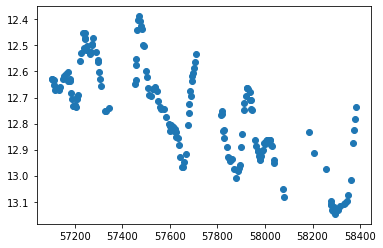

In [9]:
#raw data
plt.scatter(lc['mjd'], lc['mag'])
plt.gca().invert_yaxis()

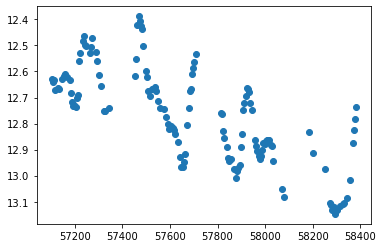

In [10]:
# #resampled data
# lc.rename(columns={'hjd':'mjd'}, inplace=True)
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [11]:
#number of days video covers
len(lc)

184

In [12]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 30.235294117647058 s


# Spectra Data Munging

In [4]:
# specify path to the spectrum
spec_path = "symbiotic/puvul.273.dat"

In [5]:
# spec = pd.read_csv(spec_path, skiprows=2)
spec = pd.read_fwf(spec_path, skiprows=1, usecols=['wave', 'flux'])
spec = spec.rename(columns={'wave': 'wavelength'})

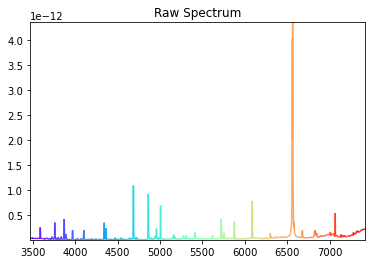

In [6]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Raw Spectrum')
plt.show()

In [7]:
preproc_spec = spectra_preproc(spec, bins=wavelength_bins())

In [8]:
preproc_spec

,Wavelength,Flux
0,3795.0,4.592816e-14
1,3805.0,2.397799e-14
2,3815.0,3.146938e-14
3,3825.0,2.516737e-14
4,3835.0,5.742001e-14
...,...,...
335,7145.0,6.973348e-14
336,7155.0,9.041996e-14
337,7165.0,7.819494e-14
338,7175.0,9.571196e-14


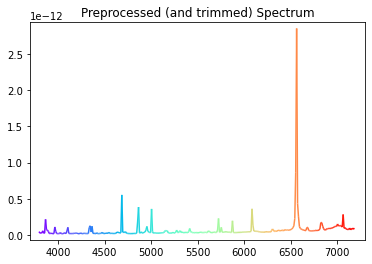

In [9]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(3700, 7300)
ax.set_ylim(np.nanmin(y)-0.5*np.nanstd(y), np.nanmax(y)+0.5*np.nanstd(y))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Preprocessed (and trimmed) Spectrum')
plt.show()

### Make the huge peak smaller

In [10]:
preproc_spec[preproc_spec['Wavelength'].between(6500,6600)]

,Wavelength,Flux
271,6505.0,7.575826e-14
272,6515.0,8.408307e-14
273,6525.0,1.009979e-13
274,6535.0,1.248596e-13
275,6545.0,2.264957e-13
276,6555.0,8.677291e-13
277,6565.0,2.855697e-12
278,6575.0,4.330190e-13
279,6585.0,2.497253e-13
280,6595.0,1.132549e-13


In [11]:
preproc_spec1 = preproc_spec.copy(deep=True)
preproc_spec1.at[277, 'Flux'] = 8.677291e-13

In [14]:
preproc_spec1['Flux'] = preproc_spec1['Flux'] * 1e13

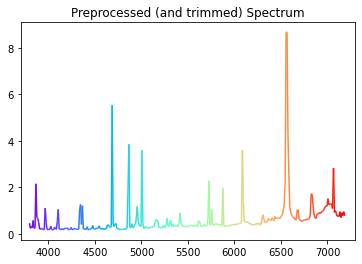

In [15]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec1['Wavelength'], preproc_spec1['Flux']
ax.set_xlim(3700, 7300)
ax.set_ylim(np.nanmin(y)-0.5*np.nanstd(y), np.nanmax(y)+0.5*np.nanstd(y))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Preprocessed (and trimmed) Spectrum')
plt.show()

# Export Preprocessed Files

In [16]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [18]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
preproc_spec1.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)